# Preprocess

prepare the json and mask

```
# input is a folder with images folder and some json-mini,
# output one processed json for all images
# brush_info is a list of brush
concate_json(folder_path)


# input is the folder with images and json
# output to a mask folder with all masks where each obj in instance id
# this can handle mixed brush or instance brush
def save_mask(json_file_path, mask_path):
```


In [ ]:
!git clone https://github.com/kew6688/MicroNuclei_Detection.git
%cd MicroNuclei_Detection
!pip install -e .

fatal: destination path 'MicroNuclei_Detection' already exists and is not an empty directory.
/content/MicroNuclei_Detection
Obtaining file:///content/MicroNuclei_Detection
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mn_segmentation (pyproject.toml) ... done
  Created wheel for mn_segmentation: filename=mn_segmentation-0.1.0-py2.py3-none-any.whl size=5157 sha256=0058d12d1315370b126bc8392a7a5af809564682c882bea189d6a63fd5936517
  Stored in directory: /tmp/pip-ephem-wheel-cache-j364191p/wheels/44/d3/d1/353d79dc8f5f434b1d33808323c1d5bb1d136026d7ae0912b8
Successfully built mn_segmentation


In [ ]:
!cp /content/drive/MyDrive/PMCC/Dataset/mnMask-2.zip /content/mnMask-2.zip
!unzip mnMask-2.zip

Streaming output truncated to the last 5000 lines.
  inflating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_13h02m-9.png  
  inflating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_14h02m-23.png  
  inflating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_14h02m-9.png  
  inflating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_15h02m-8.png  
  inflating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_16h02m-8.png  
  inflating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_17h02m-23.png  
  inflating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_17h02m-8.png  
  inflating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_18h02m-4.png  
  inflating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_19h02m-8.png  
  inflating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_20h02m-23.png  
  inflating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_20h02m-8.png  
  inflating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_22h02m-8.png  
  inflating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_23h02m-15.png  
  inflating: mnMask-2/images/GFP-H2B_A1_1_2023y0

In [ ]:
import os
import json

# input is a folder with images folder and some json-mini,
# output one processed json for all images
# brush_info is a list of brush
def concate_json(folder_path):

  out_json = []

  # read all json file
  for file in os.listdir(folder_path):
    if file.endswith('.json'):
      # Read JSON file
      with open(folder_path+file, 'r') as file:
        data = json.load(file)

        # read each annotation in json
        for anno in data:
          obj = {}
          obj['image'] = anno['image'].split('/')[-1].replace("%20", " ")
          obj['id'] = anno['id']

          annotation = {}
          if 'brush' in anno:
            annotation['brush_info'] = anno['brush']
          if 'bbox' in anno:
            annotation['bbox'] = anno['bbox']
          # TODO: polygon info and crop_box

          obj['annotation'] = annotation
          out_json.append(obj)

  print(out_json[0])

  # Define the path where you want to save the JSON file
  json_file_path = folder_path

  # Open the file in write mode and use json.dump to write the data
  with open(json_file_path+"data.json", 'w') as json_file:
      json.dump(out_json, json_file, indent=4)

In [ ]:
# copied from label studio github
# https://stackoverflow.com/questions/74339154/how-to-convert-rle-format-of-label-studio-to-black-and-white-image-masks

from typing import List
import numpy as np
import cv2

class InputStream:
    def __init__(self, data):
        self.data = data
        self.i = 0

    def read(self, size):
        out = self.data[self.i:self.i + size]
        self.i += size
        return int(out, 2)


def access_bit(data, num):
    """ from bytes array to bits by num position"""
    base = int(num // 8)
    shift = 7 - int(num % 8)
    return (data[base] & (1 << shift)) >> shift


def bytes2bit(data):
    """ get bit string from bytes data"""
    return ''.join([str(access_bit(data, i)) for i in range(len(data) * 8)])


def rle_to_mask(rle: List[int], height: int, width: int) -> np.array:
    """
    Converts rle to image mask
    Args:
        rle: your long rle
        height: original_height
        width: original_width

    Returns: np.array
    """

    rle_input = InputStream(bytes2bit(rle))

    num = rle_input.read(32)
    word_size = rle_input.read(5) + 1
    rle_sizes = [rle_input.read(4) + 1 for _ in range(4)]
    print('RLE params:', num, 'values,', word_size, 'word_size,', rle_sizes, 'rle_sizes')

    i = 0
    out = np.zeros(num, dtype=np.uint8)
    while i < num:
        x = rle_input.read(1)
        j = i + 1 + rle_input.read(rle_sizes[rle_input.read(2)])
        if x:
            val = rle_input.read(word_size)
            out[i:j] = val
            i = j
        else:
            while i < j:
                val = rle_input.read(word_size)
                out[i] = val
                i += 1

    image = np.reshape(out, [height, width, 4])[:, :, 3]
    return image

# input is the folder with images and json
# output to a mask folder with all masks where each obj in instance id
def save_mask(json_file_path, mask_path):
    # save the masks to data/masks/
    with open(json_file_path, 'r') as file:
      data = json.load(file)

      for anno in data:
        print(anno['image'])
        print(anno['id'])

        if not anno['annotation'] or 'brush_info' not in anno['annotation']: continue

        empty_mask = np.zeros((224,224))
        cnt = 0
        for i,brush in enumerate(anno['annotation']['brush_info']):
          rle = brush['rle']
          mask = rle_to_mask(rle, 224, 224)

          # Convet the mask into binary
          binary_mask = (mask > 0).astype(np.uint8)

          # Find the connected components in the image
          num_labels, labels_im = cv2.connectedComponents(binary_mask)

          # print(mask.shape)
          # print(mask.dtype)
          # print(np.unique(mask))
          for label in range(1, num_labels):  # Start from 1 to skip the background
            individual_mask = (labels_im == label).astype(np.uint8)
            if individual_mask.sum() < 5: continue
            empty_mask[individual_mask>0] = cnt+1
            cnt += 1

        # Check if the directory exists
        if not os.path.exists(mask_path):
            # Create the directory
            os.makedirs(mask_path)
        # Define the path where you want to save the array
        file_path = mask_path+'{}.npy'.format(anno['image'].split('.')[0])

        # convert to split mask
        obj_ids = np.unique(empty_mask)
        # first id is the background, so remove it.
        obj_ids = obj_ids[1:]
        # split the color-encoded mask into a set of boolean masks.
        # Note that this snippet would work as well if the masks were float values instead of ints.
        masks = empty_mask == obj_ids[:, None, None]

        # Save the array to a .npy file
        np.save(file_path, masks)


In [ ]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.1])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=1)
    ax.imshow(mask_image)

## script

In [ ]:
folder_path = "/content/"
concate_json(folder_path)

{'image': 'mCherry-H2B_B2_1_2022y08m08d_13h45m-1.png', 'id': 125388, 'annotation': {'brush_info': [{'format': 'rle', 'rle': [0, 3, 16, 0, 57, 27, 255, 255, 255, 0, 232, 124, 96, 17, 185, 71, 71, 29, 220, 114, 241, 174, 112, 54, 112, 8, 231, 112, 159, 252, 107, 124, 13, 124, 2, 52, 172, 47, 255, 28, 183, 3, 95, 0, 142, 103, 11, 255, 198, 179, 192, 215, 192, 35, 230, 194, 255, 241, 167, 240, 53, 240, 12, 47, 255, 31, 156, 98, 124, 13, 124, 2, 61, 220, 39, 255, 27, 103, 3, 99, 0, 141, 162, 223, 252, 121, 17, 171, 240, 54, 176, 8, 198, 35, 50, 140, 143, 255, 255, 128, 123, 1, 48, 0], 'brushlabels': ['mn_brush'], 'original_width': 224, 'original_height': 224}, {'format': 'rle', 'rle': [0, 3, 16, 0, 57, 27, 255, 255, 255, 0, 235, 6, 224, 17, 193, 71, 237, 30, 204, 110, 113, 139, 112, 54, 112, 8, 227, 111, 255, 199, 173, 192, 217, 192, 35, 223, 194, 127, 241, 157, 240, 54, 48, 8, 234, 47, 255, 199, 237, 24, 151, 3, 99, 0, 140, 38, 57, 8, 253, 99, 255, 142, 162, 52, 47, 255, 254, 1, 234, 108, 

In [ ]:
mask_path = "/content/grey_masks/"
json_file_path = "/content/data.json"
save_mask(json_file_path, mask_path)

mCherry-H2B_B2_1_2022y08m08d_13h45m-1.png
125388
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
mCherry-H2B_B2_1_2022y08m08d_13h45m-11.png
125389
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
mCherry-H2B_B2_1_2022y08m08d_13h45m-15.png
125390
mCherry-H2B_B2_1_2022y08m08d_13h45m-16.png
125391
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
mCherry-H2B_B2_1_2022y08m08d_13h45m-18.png
125392
mCherry-H2B_B2_1_2022y08m08d_13h45m-19.png
125393
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
mCherry-H2B_B2_1_2022y08m08d_13h45m-20.png
125394
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
mCherry-H2B_B2_1_2022y08m08d_13h45m-24.png
125395
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
mCherry-H2B_B2_1_2022y08m

In [ ]:
!zip -r grey_masks.zip grey_masks/
!cp grey_masks.zip /content/drive/MyDrive/PMCC/Dataset

updating: grey_masks/ (stored 0%)
updating: grey_masks/mCherry-H2B_E3_1_2022y08m08d_13h45m-0.npy (deflated 100%)
updating: grey_masks/mCherry-H2B_C4_2_2022y08m08d_13h45m-29.npy (deflated 100%)
updating: grey_masks/mCherry-H2B_D6_2_2022y08m08d_13h45m-14.npy (deflated 100%)
updating: grey_masks/mCherry-H2B_E5_3_2022y08m08d_13h45m-6.npy (deflated 100%)
updating: grey_masks/mCherry-H2B_E7_4_2022y08m08d_13h45m-21.npy (deflated 100%)
updating: grey_masks/mCherry-H2B_E5_1_2022y08m08d_13h45m-11.npy (deflated 100%)
updating: grey_masks/mCherry-H2B_C6_3_2022y08m08d_13h45m-27.npy (deflated 100%)
updating: grey_masks/mCherry-H2B_B3_2_2022y08m08d_13h45m-15.npy (deflated 100%)
updating: grey_masks/mCherry-H2B_B7_1_2022y08m08d_13h45m-16.npy (deflated 100%)
updating: grey_masks/mCherry-H2B_D5_1_2022y08m08d_13h45m-22.npy (deflated 100%)
updating: grey_masks/mCherry-H2B_E2_1_2022y08m08d_13h45m-18.npy (deflated 100%)
updating: grey_masks/mCherry-H2B_B3_3_2022y08m08d_13h45m-26.npy (deflated 100%)
updating

In [ ]:
!zip -r mnMask-2.zip mnMask-2/
!cp mnMask-2.zip /content/drive/MyDrive/PMCC/Dataset

Streaming output truncated to the last 5000 lines.
updating: mnMask-2/images/GFP-H2B_A2_1_2023y07m02d_13h02m-19.png
	zip warning: Local Entry CRC does not match CD: mnMask-2/images/GFP-H2B_A2_1_2023y07m02d_13h02m-19.png
 (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A2_1_2023y07m02d_13h02m-4.png
	zip warning: Local Entry CRC does not match CD: mnMask-2/images/GFP-H2B_A2_1_2023y07m02d_13h02m-4.png
 (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A2_1_2023y07m02d_14h02m-0.png
	zip warning: Local Entry CRC does not match CD: mnMask-2/images/GFP-H2B_A2_1_2023y07m02d_14h02m-0.png
 (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A2_1_2023y07m02d_14h02m-19.png
	zip warning: Local Entry CRC does not match CD: mnMask-2/images/GFP-H2B_A2_1_2023y07m02d_14h02m-19.png
 (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A2_1_2023y07m02d_14h02m-4.png
	zip warning: Local Entry CRC does not match CD: mnMask-2/images/GFP-H2B_A2_1_2023y07m02d_14h02m-4.png
 (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A

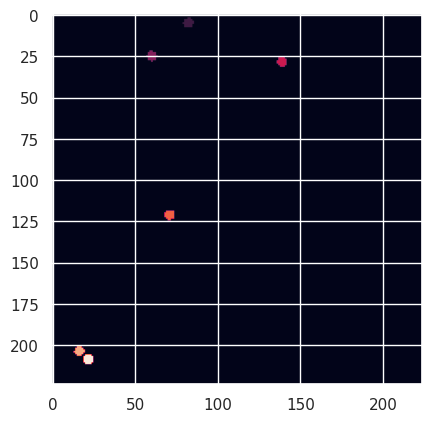

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

masks = np.load("/content/mnMask-2/masks/10 Gy_GFP-H2B_A1_3_2023y06m26d_00h57m-28.npy")
plt.imshow(masks)

NameError: name 'show_mask' is not defined

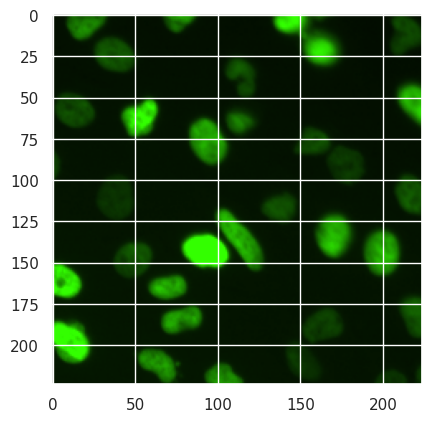

In [ ]:
from PIL import Image
im = Image.open("/content/mnMask-2/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_17h57m-23.png")
plt.imshow(im)
show_mask(masks>0,plt)

# Refine the mask

In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

!mkdir -p images
!wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/groceries.jpg

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-c6jjvij9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-c6jjvij9
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cache

In [5]:
# @title Set-up

import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):

    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.1])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask = mask.squeeze()
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

using device: cuda


In [3]:
from PIL import Image
from torchvision.ops import masks_to_boxes

def load_input(img_path, label_mask_path):
    '''
    Generate input for sam predictor. Each image path will return one numpy image
      and a np array of boxes input

    Args:
      img_path, str: path to image
      label_mask_path, str: path to label mask

    Returns:
      img: numpy array
      boxes: numpy array of boxes input in shape [n,4]

    '''
    img = Image.open(img_path)
    img = np.array(img.convert("RGB"))

    label = np.load(label_mask_path)
    masks = torch.from_numpy(label)
    # We get the unique colors, as these would be the object ids.
    # obj_ids = torch.unique(mask)

    # first id is the background, so remove it.
    # obj_ids = obj_ids[1:]

    # split the color-encoded mask into a set of boolean masks.
    # Note that this snippet would work as well if the masks were float values instead of ints.
    # masks = mask == obj_ids[:, None, None]
    # print(masks.size(),torch.where(masks[0] != 0))
    boxes = masks_to_boxes(masks).numpy()
    # print(boxes.size())
    # print(boxes.numpy())

    return img, boxes

In [2]:
import os
from tqdm import tqdm
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

def refine_mask(mask_path, img_path, dest, batch_sz=16):
  label_mask_dir = mask_path
  label_mask_lst = sorted(os.listdir(label_mask_dir))

  img_dir = img_path

  img_batch = []
  boxes_batch = []
  output_name = []
  for label_mask in label_mask_lst:
      img_name = label_mask.split('.')[0] + '.png'
      img_path = os.path.join(img_dir, img_name)
      label_mask_path = os.path.join(label_mask_dir, label_mask)

      img, boxes = load_input(img_path, label_mask_path)
      if boxes.shape[0] == 0:
        continue
      img_batch.append(img)
      boxes_batch.append(boxes)
      output_name.append(label_mask)

  sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
  model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

  sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

  output = []
  for i in tqdm(range(0, len(img_batch), batch_sz)):
    predictor = SAM2ImagePredictor(sam2_model)
    predictor.set_image_batch(img_batch[i:i+batch_sz])
    masks_batch, scores_batch, _ = predictor.predict_batch(
        None,
        None,
        box_batch=boxes_batch[i:i+batch_sz],
        multimask_output=False
    )
    output += masks_batch

    # clean ram
    del predictor
    import gc
    gc.collect()
    torch.cuda.empty_cache()

  if not os.path.exists(dest):
    os.makedirs(dest)
  for i in range(len(output)):
    np.save(f"{os.path.join(dest,output_name[i])}", output[i])

## script

In [6]:
# !cp /content/drive/MyDrive/PMCC/Dataset/mCherryMask_v3.zip /content/
# !unzip /content/mCherryMask_v3.zip -d /content/
# mask_path = "/content/mCherryMask_v3/grey_masks"
# img_path = "/content/mCherryMask_v3/images"
# dest = "/content/mCherryMask_v3/refined_masks"
# refine_mask(mask_path,img_path,dest)

100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


In [8]:
import os
import shutil

def move_npy_files(source_folder, destination_folder):
    # Ensure the destination folder exists
    os.makedirs(destination_folder, exist_ok=True)

    # Loop through files in the source folder
    for file_name in os.listdir(source_folder):
        if file_name.endswith('.npy'):
            source_path = os.path.join(source_folder, file_name)
            destination_path = os.path.join(destination_folder, file_name)

            # Move the file
            shutil.move(source_path, destination_path)
            print(f"Moved: {file_name}")

    print("All .npy files have been moved.")

# Example usage
move_npy_files('/content/mCherryMask_v3', dest)


Moved: refined_masksmCherry-H2B_D7_2_2022y08m08d_13h45m-28.npy
Moved: refined_masksmCherry-H2B_D4_3_2022y08m08d_13h45m-28.npy
Moved: refined_masksmCherry-H2B_E6_3_2022y08m08d_13h45m-19.npy
Moved: refined_masksmCherry-H2B_B3_1_2022y08m08d_13h45m-15.npy
Moved: refined_masksmCherry-H2B_E7_2_2022y08m08d_13h45m-0.npy
Moved: refined_masksmCherry-H2B_E6_1_2022y08m08d_13h45m-19.npy
Moved: refined_masksmCherry-H2B_B5_1_2022y08m08d_13h45m-14.npy
Moved: refined_masksmCherry-H2B_E6_1_2022y08m08d_13h45m-3.npy
Moved: refined_masksmCherry-H2B_E3_4_2022y08m08d_13h45m-14.npy
Moved: refined_masksmCherry-H2B_B6_2_2022y08m08d_13h45m-3.npy
Moved: refined_masksmCherry-H2B_D4_1_2022y08m08d_13h45m-23.npy
Moved: refined_masksmCherry-H2B_E7_3_2022y08m08d_13h45m-22.npy
Moved: refined_masksmCherry-H2B_D4_3_2022y08m08d_13h45m-15.npy
Moved: refined_masksmCherry-H2B_E4_4_2022y08m08d_13h45m-0.npy
Moved: refined_masksmCherry-H2B_B3_3_2022y08m08d_13h45m-29.npy
Moved: refined_masksmCherry-H2B_E6_3_2022y08m08d_13h45m-22.

In [11]:
!zip -r mCherryMask_v4.zip mCherryMask_v4/
!cp mCherryMask_v4.zip /content/drive/MyDrive/PMCC/Dataset

  adding: mCherryMask_v4/ (stored 0%)
  adding: mCherryMask_v4/images/ (stored 0%)
  adding: mCherryMask_v4/images/mCherry-H2B_E6_3_2022y08m08d_13h45m-7.png (deflated 0%)
  adding: mCherryMask_v4/images/mCherry-H2B_E6_2_2022y08m08d_13h45m-24.png (deflated 0%)
  adding: mCherryMask_v4/images/mCherry-H2B_E6_2_2022y08m08d_13h45m-23.png (deflated 0%)
  adding: mCherryMask_v4/images/mCherry-H2B_B2_3_2022y08m08d_13h45m-3.png (deflated 0%)
  adding: mCherryMask_v4/images/mCherry-H2B_B2_1_2022y08m08d_13h45m-12.png (deflated 0%)
  adding: mCherryMask_v4/images/mCherry-H2B_E7_1_2022y08m08d_13h45m-12.png (stored 0%)
  adding: mCherryMask_v4/images/mCherry-H2B_E5_2_2022y08m08d_13h45m-20.png (deflated 0%)
  adding: mCherryMask_v4/images/mCherry-H2B_B4_4_2022y08m08d_13h45m-29.png (deflated 0%)
  adding: mCherryMask_v4/images/mCherry-H2B_B2_3_2022y08m08d_13h45m-14.png (deflated 0%)
  adding: mCherryMask_v4/images/mCherry-H2B_E7_1_2022y08m08d_13h45m-14.png (deflated 0%)
  adding: mCherryMask_v4/images

In [ ]:
mask_path = "/content/mnMask-2/masks/"
img_path = "/content/mnMask-2/images/"
dest = "/content/mnMask-2/refined_masks/"
refine_mask(mask_path,img_path,dest)

100%|██████████| 102/102 [01:30<00:00,  1.12it/s]


In [ ]:
!zip -r mnMask-2.zip mnMask-2/
!cp mnMask-2.zip /content/drive/MyDrive/PMCC/Dataset

Streaming output truncated to the last 5000 lines.
updating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_13h02m-9.png (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_14h02m-23.png (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_14h02m-9.png (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_15h02m-8.png (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_16h02m-8.png (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_17h02m-23.png (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_17h02m-8.png (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_18h02m-4.png (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_19h02m-8.png (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_20h02m-23.png (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_20h02m-8.png (deflated 0%)
updating: mnMask-2/images/GFP-H2B_A1_1_2023y06m30d_22h02m-8.png (deflated 0%)
updating: 

In [ ]:
from google.colab import runtime
runtime.unassign()

## review

In [ ]:
from torchvision.ops import masks_to_boxes
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

mask_path = "/content/mnMask-2/masks/"
imgd_path = "/content/mnMask-2/images/"
refined_path = "/content/mnMask-2/refined_masks/"

i = 0
for file in os.listdir(mask_path):
  img_path = os.path.join(imgd_path,file.split('.')[0]+'.png')
  refine_mask_path = os.path.join(refined_path,file)
  refine_masks = np.load(refine_mask_path)

  image = Image.open(img_path)
  image = np.array(image.convert("RGB"))

  label_mask_path = os.path.join(mask_path+file)
  label_path = np.load(label_mask_path)

  # Create a figure and arrange subplots in a single row
  fig, axes = plt.subplots(1, 2, figsize=(20, 10))

  # Plotting on each subplot
  axes[0].imshow(image)
  for mask in refine_masks:
      show_mask(mask, axes[0], random_color=False)
  axes[0].set_title('Original Mask')

  axes[1].imshow(label_path>0)
  for mask in refine_masks:
      show_mask(mask, axes[1], random_color=False)
  axes[1].set_title('Refined Mask')

  plt.axis('off')
  plt.title(f'image {i}')
  i += 1
  plt.show()

In [ ]:
import os
mask_path = "/content/mnMask-2/masks/"
os.listdir(mask_path)[-5]

'10 Gy_GFP-H2B_A1_3_2023y06m26d_00h57m-28.npy'

In [ ]:
bad = set([1,12,27,42,48,54,57,59,60,64,69,98,99,108,110,111,112,124,132,156,164,165,184,189,191,194,199,200,203,201,205,210,213,223,
       225,233,240,246,256,258,262,268,271,272,276,277,278,282,284,301,320,328,330,343,346,351,358,362,364,380,378,398,
       400,411,415,429,432,433,436,439,444,451,479,487,491,494,504,507,508,522,523,538,553,575,595,607,646,654,661,684,700,723,737,
       740,795,812,839,843,883,889,901,913,918,925,932,936,944,946,997,1009,1015,1040,1072,1081,1088,1110,1130,1151,1157,1160,1162,
       1169,1171,1209,1252,1259,1263,1300,1302,1397,1462,1487,1598])
print(len(bad))

133


In [ ]:
import shutil

# Define the source and destination directories
source_dir = '/content/mnMask-2/refined_masks'
destination_dir = '/content/mnMask-2/final_masks'

# Make sure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

cnt = 0
mn_cnt = 0
# Loop through files in the source directory
for i,filename in enumerate(os.listdir(source_dir)):
    # Construct full file path
    source_file = os.path.join(source_dir, filename)
    destination_file = os.path.join(destination_dir, filename)

    # Check if it is a file (and not a directory), then copy
    if i not in bad and os.path.isfile(source_file):
        shutil.copy(source_file, destination_file)
        cnt += 1
        mask = np.load(source_file)
        mn_cnt += len(mask)
        if mask.ndim == 2:
          print("!!!!!!!!!!!!!!!!!!!")
          print(mask.shape)
print(cnt + len(bad) == len(os.listdir(source_dir)))
print(cnt, mn_cnt)

False
1495 3155


In [ ]:
source_dir = '/content/mnMask_v2/final_masks'
mn_cnt = 0
# Loop through files in the source directory
for i,filename in enumerate(os.listdir(source_dir)):
    # Construct full file path
    source_file = os.path.join(source_dir, filename)

    # Check if it is a file (and not a directory), then copy
    mask = np.load(source_file)
    mn_cnt += len(mask)
    # print(mask.shape)
    # break
print(len(os.listdir(source_dir)), mn_cnt)

1829 3581


In [ ]:
3027+477

3504

In [ ]:
!zip -r mCherryMask.zip /content/mCherryMask/
!cp mCherryMask.zip /content/drive/MyDrive/PMCC/Dataset

  adding: content/mCherryMask/ (stored 0%)
  adding: content/mCherryMask/.ipynb_checkpoints/ (stored 0%)
  adding: content/mCherryMask/images/ (stored 0%)
  adding: content/mCherryMask/images/mCherry-H2B_E3_2_2022y08m08d_13h45m-13.png (deflated 0%)
  adding: content/mCherryMask/images/mCherry-H2B_E7_1_2022y08m08d_13h45m-20.png (deflated 0%)
  adding: content/mCherryMask/images/mCherry-H2B_E6_3_2022y08m08d_13h45m-27.png (deflated 0%)
  adding: content/mCherryMask/images/mCherry-H2B_B6_2_2022y08m08d_13h45m-24.png (deflated 0%)
  adding: content/mCherryMask/images/mCherry-H2B_D7_2_2022y08m08d_13h45m-29.png (deflated 0%)
  adding: content/mCherryMask/images/mCherry-H2B_C5_3_2022y08m08d_13h45m-16.png (stored 0%)
  adding: content/mCherryMask/images/mCherry-H2B_B4_4_2022y08m08d_13h45m-0.png (deflated 0%)
  adding: content/mCherryMask/images/mCherry-H2B_E7_3_2022y08m08d_13h45m-7.png (deflated 0%)
  adding: content/mCherryMask/images/mCherry-H2B_B2_3_2022y08m08d_13h45m-27.png (stored 0%)
  add

In [ ]:
import os
import shutil
import json

data = json.load(open("/content/mnMask-2/mini-mcherry.json"))
name_set = set()
for d in data:
  name_set.add(d["image"].split('/')[-1].split('.')[0])

# Source and destination directories
source_dir = "/content/mnMask-2/refined_masks"
# destination_dir = "/content/mnMask-2/refined_masks"

# List of files to move
files_to_move = os.listdir(source_dir)

# Ensure the destination directory exists
# os.makedirs(destination_dir, exist_ok=True)

# Move files
for file_name in files_to_move:
    source_path = os.path.join(source_dir, file_name)
    # destination_path = os.path.join(destination_dir, file_name)
    if file_name.split('.')[0] in name_set:  # Check if the file exists
        os.remove(source_path)
        print(f"Removed {file_name}")


Removed mCherry-H2B_E7_4_2022y08m08d_13h45m-28.npy
Removed mCherry-H2B_B6_2_2022y08m08d_13h45m-24.npy
Removed mCherry-H2B_D5_4_2022y08m08d_13h45m-28.npy
Removed mCherry-H2B_B2_2_2022y08m08d_13h45m-14.npy
Removed mCherry-H2B_E7_3_2022y08m08d_13h45m-6.npy
Removed mCherry-H2B_E5_4_2022y08m08d_13h45m-1.npy
Removed mCherry-H2B_B3_1_2022y08m08d_13h45m-15.npy
Removed mCherry-H2B_E5_2_2022y08m08d_13h45m-22.npy
Removed mCherry-H2B_E6_1_2022y08m08d_13h45m-21.npy
Removed mCherry-H2B_E6_1_2022y08m08d_13h45m-27.npy
Removed mCherry-H2B_B4_2_2022y08m08d_13h45m-1.npy
Removed mCherry-H2B_B3_2_2022y08m08d_13h45m-3.npy
Removed mCherry-H2B_B7_3_2022y08m08d_13h45m-16.npy
Removed mCherry-H2B_B4_2_2022y08m08d_13h45m-7.npy
Removed mCherry-H2B_B3_1_2022y08m08d_13h45m-24.npy
Removed mCherry-H2B_B2_2_2022y08m08d_13h45m-19.npy
Removed mCherry-H2B_D4_2_2022y08m08d_13h45m-21.npy
Removed mCherry-H2B_B7_1_2022y08m08d_13h45m-15.npy
Removed mCherry-H2B_C3_1_2022y08m08d_13h45m-10.npy
Removed mCherry-H2B_D7_2_2022y08m08d

## merge

In [ ]:
!cp /content/drive/MyDrive/PMCC/Dataset/mnMaskFinal.zip /content/
!unzip mnMaskFinal.zip

Archive:  mnMaskFinal.zip
   creating: mnMask/
   creating: mnMask/data/
   creating: mnMask/data/label_masks/
  inflating: mnMask/data/label_masks/GFP-H2B_A1_1_2023y07m01d_00h02m-14.npy  
  inflating: mnMask/data/label_masks/Plate 1_GFP-H2B_O12_1_2022y12m03d_19h30m-22.npy  
  inflating: mnMask/data/label_masks/10 Gy_GFP-H2B_B1_2_2023y06m25d_16h17m_1.npy  
  inflating: mnMask/data/label_masks/GFP-H2B_A1_1_2023y06m30d_19h02m-12.npy  
  inflating: mnMask/data/label_masks/Plate 1_GFP-H2B_J14_1_2022y12m02d_19h30m-29.npy  
  inflating: mnMask/data/label_masks/GFP-H2B_A1_1_2023y07m01d_21h02m-15.npy  
  inflating: mnMask/data/label_masks/10 Gy_GFP-H2B_A2_1_2023y06m25d_06h17m_0.npy  
  inflating: mnMask/data/label_masks/GFP-H2B_A1_1_2023y07m03d_08h02m-10.npy  
  inflating: mnMask/data/label_masks/10 Gy_GFP-H2B_A1_1_2023y06m26d_01h17m_3.npy  
  inflating: mnMask/data/label_masks/GFP-H2B_A1_1_2023y07m03d_00h02m-15.npy  
  inflating: mnMask/data/label_masks/Plate 1_GFP-H2B_D19_1_2022y12m03d_23h30

In [ ]:
import os
import shutil

# Source and destination directories
source_dir = "/content/mnMask/data/final_masks"
destination_dir = "/content/mnMask_v2/final_masks"

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

cnt = 0
# Copy all files from source to destination
for file_name in os.listdir(source_dir):
    source_path = os.path.join(source_dir, file_name)
    destination_path = os.path.join(destination_dir, file_name)

    # Copy only files (skip directories)
    if not os.path.exists(destination_path):
        shutil.copy2(source_path, destination_path)  # Use copy2 to preserve metadata
        # print(f"Copied {file_name} to {destination_dir}")
    else:
      cnt += 1
      print("exist "+file_name)
print(cnt)

exist 10 Gy_GFP-H2B_A1_1_2023y06m24d_18h57m-9.npy
exist GFP-H2B_A1_1_2023y06m30d_20h02m-8.npy
exist GFP-H2B_A1_1_2023y07m03d_03h02m-0.npy
exist 10 Gy_GFP-H2B_A1_1_2023y06m24d_16h57m-9.npy
exist 10 Gy_GFP-H2B_A1_1_2023y06m24d_05h57m-3.npy
exist GFP-H2B_A1_1_2023y07m01d_11h02m-0.npy
exist 10 Gy_GFP-H2B_A1_1_2023y06m24d_08h57m-6.npy
exist 10 Gy_GFP-H2B_A1_1_2023y06m23d_17h57m-22.npy
exist GFP-H2B_A1_1_2023y07m02d_23h02m-12.npy
exist GFP-H2B_A1_1_2023y07m03d_05h02m-0.npy
exist 10 Gy_GFP-H2B_A1_1_2023y06m24d_15h57m-27.npy
exist GFP-H2B_A1_1_2023y07m03d_00h02m-0.npy
exist 10 Gy_GFP-H2B_A1_1_2023y06m24d_05h57m-13.npy
exist 10 Gy_GFP-H2B_A1_1_2023y06m23d_21h57m-18.npy
exist GFP-H2B_A1_1_2023y07m03d_00h02m-12.npy
exist 10 Gy_GFP-H2B_A1_1_2023y06m23d_17h57m-23.npy
exist GFP-H2B_A1_1_2023y07m02d_21h02m-12.npy
exist GFP-H2B_A1_1_2023y07m01d_06h02m-0.npy
exist 10 Gy_GFP-H2B_A1_1_2023y06m24d_16h57m-10.npy
exist 10 Gy_GFP-H2B_A1_1_2023y06m24d_03h57m-16.npy
exist 10 Gy_GFP-H2B_A1_1_2023y06m24d_03h57m-

In [ ]:
import os
import numpy as np

# Input and output directories
input_dir = "/content/mnMask_v2/final_masks"
output_dir = "/content/mnMask_v2/final_masks"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process each `.npy` file in the input directory
for file_name in os.listdir(input_dir):
    if file_name.endswith(".npy"):  # Check if it's an `.npy` file
        input_path = os.path.join(input_dir, file_name)
        output_path = os.path.join(output_dir, file_name)

        # Load the .npy file
        array = np.load(input_path)

        # Squeeze the array
        squeezed_array = np.squeeze(array)
        if squeezed_array.ndim == 2:
          squeezed_array = np.expand_dims(squeezed_array, axis=0)

        # Save the squeezed array back to a new .npy file
        np.save(output_path, squeezed_array)
        print(f"Processed and saved: {file_name}")

Processed and saved: GFP-H2B_A1_2_2023y07m02d_08h02m-17.npy
Processed and saved: 10 Gy_GFP-H2B_B1_2_2023y06m25d_07h17m_0.npy
Processed and saved: 10 Gy_GFP-H2B_A1_1_2023y06m24d_18h57m-9.npy
Processed and saved: GFP-H2B_A2_1_2023y07m02d_21h02m-4.npy
Processed and saved: GFP-H2B_A1_3_2023y07m01d_01h02m-8.npy
Processed and saved: GFP-H2B_A1_2_2023y07m02d_14h02m-18.npy
Processed and saved: GFP-H2B_A3_4_2023y07m01d_18h02m-21.npy
Processed and saved: 10 Gy_GFP-H2B_A2_1_2023y06m25d_09h17m_0.npy
Processed and saved: Plate 1_GFP-H2B_C9_1_2022y12m05d_23h30m-22.npy
Processed and saved: GFP-H2B_A2_1_2023y07m02d_13h02m-4.npy
Processed and saved: GFP-H2B_A1_1_2023y06m30d_21h02m-12.npy
Processed and saved: GFP-H2B_A1_1_2023y07m03d_02h02m-13.npy
Processed and saved: GFP-H2B_A1_2_2023y07m02d_20h02m-19.npy
Processed and saved: GFP-H2B_A1_2_2023y07m01d_14h02m-21.npy
Processed and saved: GFP-H2B_A1_1_2023y07m01d_12h02m-22.npy
Processed and saved: GFP-H2B_A4_2_2023y07m02d_02h02m-7.npy
Processed and saved: 

In [ ]:
!zip -r mnMask_v2.zip mnMask_v2/
!cp mnMask_v2.zip /content/drive/MyDrive/PMCC/Dataset/

Streaming output truncated to the last 5000 lines.
  adding: mnMask_v2/brush_masks/GFP-H2B_A1_3_2023y07m01d_03h02m-8.npy (deflated 100%)
  adding: mnMask_v2/brush_masks/10 Gy_GFP-H2B_B1_2_2023y06m25d_08h17m_0.npy (deflated 100%)
  adding: mnMask_v2/brush_masks/GFP-H2B_A3_4_2023y06m30d_17h02m-10.npy (deflated 100%)
  adding: mnMask_v2/brush_masks/10 Gy_GFP-H2B_A2_1_2023y06m25d_08h17m_0.npy (deflated 100%)
  adding: mnMask_v2/brush_masks/GFP-H2B_A1_4_2023y07m03d_08h02m-9.npy (deflated 100%)
  adding: mnMask_v2/brush_masks/Plate 1_GFP-H2B_N2_1_2022y12m02d_23h30m-11.npy (deflated 100%)
  adding: mnMask_v2/brush_masks/10 Gy_GFP-H2B_A1_2_2023y06m23d_22h57m-0.npy (deflated 100%)
  adding: mnMask_v2/brush_masks/GFP-H2B_A1_3_2023y06m30d_12h02m-8.npy (deflated 100%)
  adding: mnMask_v2/brush_masks/GFP-H2B_A3_2_2023y06m30d_20h02m-18.npy (deflated 100%)
  adding: mnMask_v2/brush_masks/GFP-H2B_A2_2_2023y07m01d_02h02m-5.npy (deflated 100%)
  adding: mnMask_v2/brush_masks/10 Gy_GFP-H2B_A1_1_2023y06m2

# figure

In [ ]:
from collections import Counter
import os
import numpy as np

# Input and output directories
input_dir = "/content/mnMask_v2/final_masks"

l = []
# Process each `.npy` file in the input directory
for file_name in os.listdir(input_dir)[:-200]:
    if file_name.endswith(".npy"):  # Check if it's an `.npy` file
        input_path = os.path.join(input_dir, file_name)
        mask = np.load(input_path)
        l.append(len(mask))

cnt = Counter(l)


In [ ]:
cnt

Counter({1: 1120,
         8: 19,
         2: 228,
         3: 82,
         4: 66,
         16: 3,
         6: 17,
         5: 36,
         12: 5,
         21: 1,
         15: 4,
         7: 15,
         13: 5,
         11: 6,
         10: 4,
         9: 12,
         18: 1,
         22: 1,
         14: 2,
         17: 2})

In [ ]:
# images cnt by mn number
# mn contribution by catogory


Text(0.5, 1.0, 'micronuclei contribution')

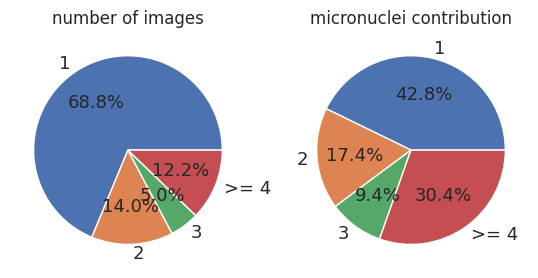

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.gridspec import GridSpec

labels = '1', '2', '3', '>= 4'
sizes = [cnt[1], cnt[2], cnt[3], 0]
mn_contri = [0]*4
for k, v in cnt.items():
  sizes[3] += v if k > 3 else 0
  k = k if k < 4 else 4
  mn_contri[k-1] += v*k

fig = plt.figure(figsize = (14, 14))# ,constrained_layout=True
sn.set()
sn.color_palette("hls", 8)

gs = GridSpec(nrows=2, ncols=4, hspace=0, figure=fig) #height_ratios=[1.0, 0.40],
fig.subplots_adjust(top=0.65, bottom=0.25, hspace=0.0)

ax1 = fig.add_subplot(gs[0,0])
ax1.pie(sizes, labels = labels, autopct='%1.1f%%', textprops={'fontsize': 13})
ax1.set_title("number of images")

ax2 = fig.add_subplot(gs[0,1])
ax2.pie(mn_contri, labels = labels, autopct='%1.1f%%', textprops={'fontsize': 13})
ax2.set_title("micronuclei contribution")